In [1]:
import glob
import os
import csv
import random
import math
import zipfile
import io
from itertools import product

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import manifold, datasets, decomposition
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ExpSineSquared, ConstantKernel as C
from sklearn.model_selection import train_test_split

In [3]:

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel as C

# Load Data

In [4]:
def read_data(path):
    data = []
    
    for file_path in glob.glob(f'{path}/**/Magnetometer.csv', recursive=True):
        df = pd.read_csv(file_path, delimiter='\t')
        cord = file_path.split('/')[2].split('_')[2:]
        cord = (float(cord[0]), float(cord[1]))
        
        mean_mag = df[["X (µT)", "Y (µT)", "Z (µT)"]].mean().to_numpy()
#         data.append(np.concatenate((cord, mean_mag)))
        data.append(np.concatenate((cord, mean_mag)))
        
    return np.array(data)

In [5]:
grid_data = read_data('./Grid/')
float_grid_data = read_data('./FloatGrid/')
testing_grid_data = read_data('./TestingGrid/')

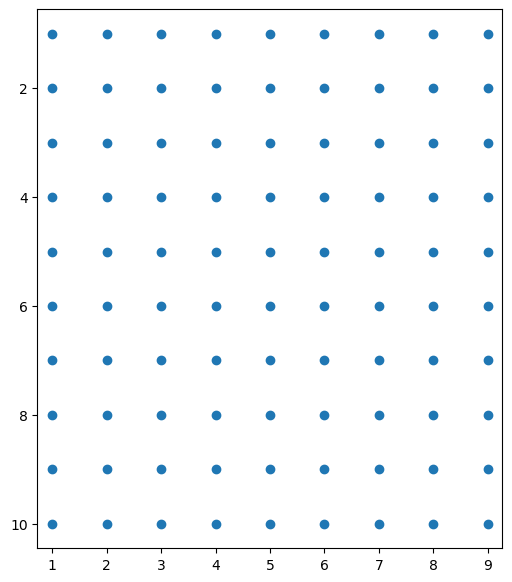

In [6]:
grid_x = grid_data[:, 1]
grid_y = grid_data[:, 0]

plt.figure(figsize=(6, 7))
plt.scatter(grid_x, grid_y)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

# GPR

## Training

In [7]:
kernel = C(8.0, (5.0, 50.)) * RBF(length_scale=2.5, length_scale_bounds=(0.5, 3.0)) + C(1.0, (0.05, 5.0)) * RBF(length_scale=0.075, length_scale_bounds=(0.05, 0.1))
# kernel = RBF(length_scale=0.85, length_scale_bounds=(0.5, 6))
# kernely = C(8.0, (5.0, 50.)) * RBF(length_scale=2.5, length_scale_bounds=(0.5, 3.0))
# kernelz = RBF(length_scale=0.01, length_scale_bounds=(0.001, 0.1)) + RBF(length_scale=5.0, length_scale_bounds=(2.0, 50.0)) + ExpSineSquared(length_scale_bounds=(0.01, 5.0))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50)

In [8]:
pos = grid_data[:, :2]
mag = grid_data[:, 2:]

gp.fit(pos, mag)

/root/miniconda3/envs/mag39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/miniconda3/envs/mag39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 5.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=2.83**2 * RBF(length_scale=2.5) + 1**2 * RBF(length_scale=0.075),
                         n_restarts_optimizer=50)

In [9]:
pred, MSE = gp.predict(pos, return_std=True)
gpr_error = pred - mag
print(np.abs(gpr_error).mean(axis=0), gpr_error.mean(), gpr_error.std())

[2.61230344e-11 2.46420915e-11 1.55350695e-11] 3.536642301032805e-12 4.5358221049945146e-11


In [10]:
def plot_mag(c):
    plt.figure(figsize=(7, 6))
    plt.scatter(yx[:, 1], yx[:, 0], c=gpr_output_data[:, c])

    plt.scatter(grid_data[:, 1], grid_data[:, 0], c=grid_data[:, c+2])
    # plt.scatter(float_grid_data[:, 1], float_grid_data[:, 0], c=float_grid_data[:, c+2])
    # plt.scatter(testing_grid_data[:, 1], testing_grid_data[:, 0], c=testing_grid_data[:, c+2])

    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.colorbar()
    plt.show()


## Plot

In [11]:
(0, 4.8), (0, 5.4)
(-0.36, 5.161, -0.36, 5.761)

(-0.36, 5.161, -0.36, 5.761)

In [12]:
y = np.arange(-0.36, 5.761, 0.12) / 0.6 + 1
x = np.arange(-0.36, 5.161, 0.12) / 0.6 + 1

yx = np.array(list(product(y, x)))

gpr_output_data, MSE = gp.predict(yx, return_std=True)

In [13]:
y.shape, x.shape

((52,), (47,))

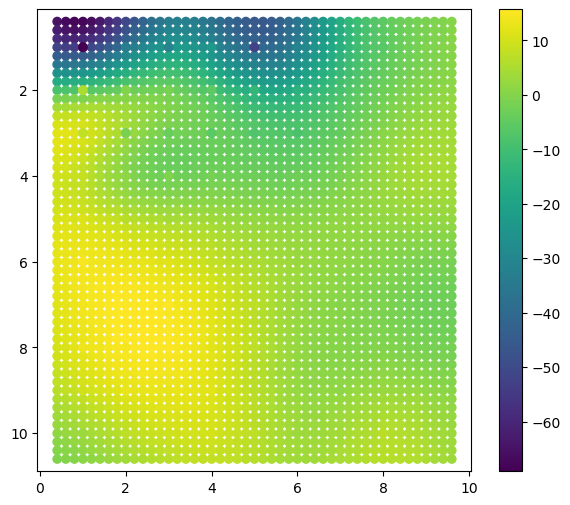

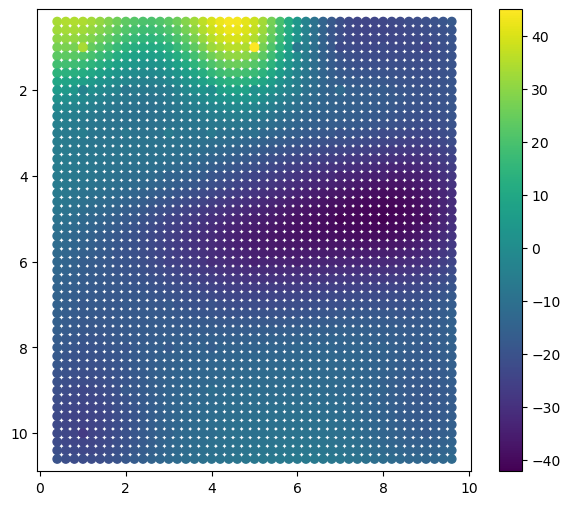

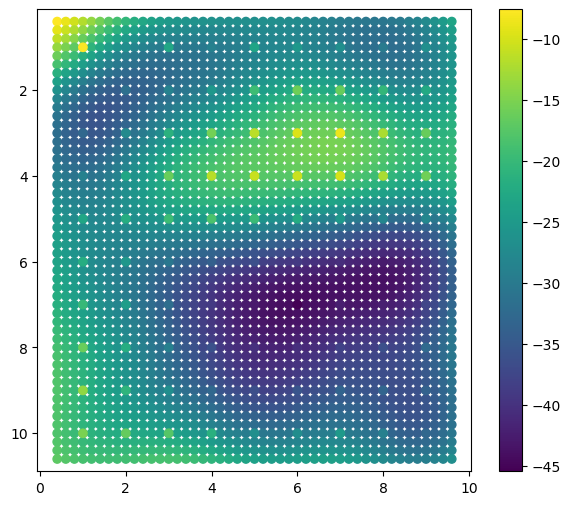

In [14]:
plot_mag(c=0)
plot_mag(c=1)
plot_mag(c=2)

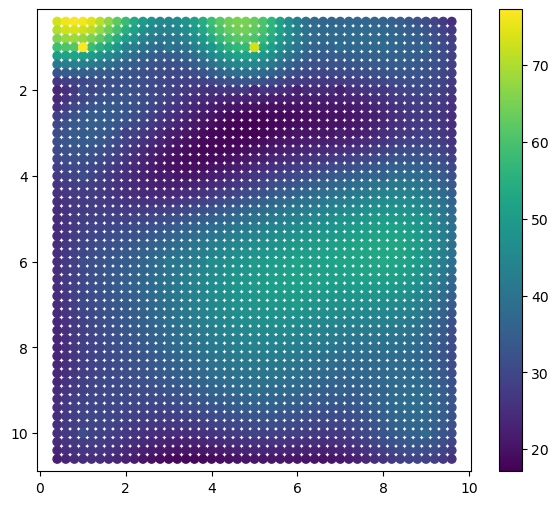

In [15]:
plt.figure(figsize=(7, 6))
gpr_t = np.sqrt(np.sum(np.power(gpr_output_data, 2), axis=-1))
plt.scatter(yx[:, 1], yx[:, 0], c=gpr_t)

grid_t = np.sqrt(np.sum(np.power(grid_data[:, 2:], 2), axis=-1))
plt.scatter(grid_data[:, 1], grid_data[:, 0], c=grid_t)
# plt.scatter(float_grid_data[:, 1], float_grid_data[:, 0], c=float_grid_data[:, c+2])
# plt.scatter(testing_grid_data[:, 1], testing_grid_data[:, 0], c=testing_grid_data[:, c+2])

plt.gca().invert_yaxis()
plt.axis('equal')
plt.colorbar()
plt.show()

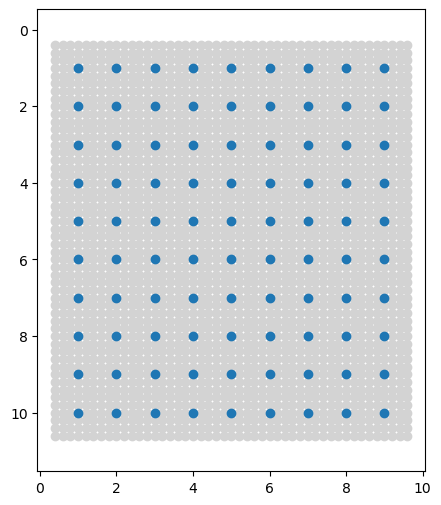

In [41]:
plt.figure(figsize=(5, 6))
gpr_t = np.sqrt(np.sum(np.power(gpr_output_data, 2), axis=-1))
plt.scatter(yx[:, 1], yx[:, 0], c='lightgray')

grid_t = np.sqrt(np.sum(np.power(grid_data[:, 2:], 2), axis=-1))
plt.scatter(grid_data[:, 1], grid_data[:, 0], c='tab:blue')
# plt.scatter(float_grid_data[:, 1], float_grid_data[:, 0], c=float_grid_data[:, c+2])
# plt.scatter(testing_grid_data[:, 1], testing_grid_data[:, 0], c=testing_grid_data[:, c+2])

plt.gca().invert_yaxis()
plt.axis('equal')
# plt.colorbar()
plt.show()

# Generate Trajectory

In [187]:
gpr_output_data.shape

(2444, 3)

In [256]:
grid_phase = np.zeros(len(gpr_output_data))

grid_idx = np.arange(len(gpr_output_data))
model_selection_idx, testing_idx = train_test_split(grid_idx, train_size=0.8, shuffle=True)
# training_idx, validation_idx = train_test_split(model_selection_idx, train_size=0.8, shuffle=True)

grid_phase[model_selection_idx] = 1
# grid_phase[validation_idx] = 2
grid_phase[testing_idx] = 2

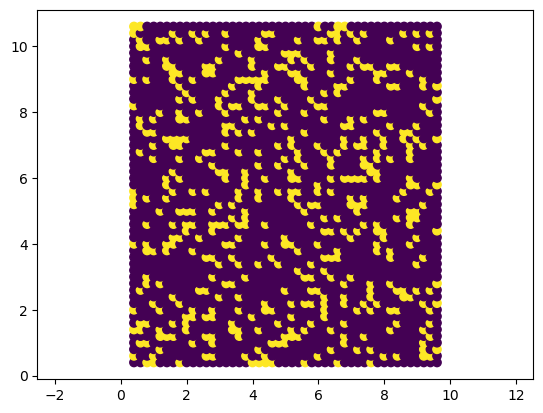

In [257]:
plt.figure()

plt.scatter(yx[:, 1], yx[:, 0], c=grid_phase)

plt.axis('equal')
plt.show()

In [258]:
gpr_output_data.shape, grid_phase[:, None].shape

((2444, 3), (2444, 1))

In [186]:
yx * 0.6

array([[0.24, 0.24],
       [0.24, 0.36],
       [0.24, 0.48],
       ...,
       [6.36, 5.52],
       [6.36, 5.64],
       [6.36, 5.76]])

In [184]:
x * 0.6

array([0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96, 1.08, 1.2 , 1.32, 1.44,
       1.56, 1.68, 1.8 , 1.92, 2.04, 2.16, 2.28, 2.4 , 2.52, 2.64, 2.76,
       2.88, 3.  , 3.12, 3.24, 3.36, 3.48, 3.6 , 3.72, 3.84, 3.96, 4.08,
       4.2 , 4.32, 4.44, 4.56, 4.68, 4.8 , 4.92, 5.04, 5.16, 5.28, 5.4 ,
       5.52, 5.64, 5.76])

In [259]:
grids = np.concatenate((yx * 0.6, gpr_output_data, grid_phase[:, None]), axis=-1)
np.save(f'./Data/grid_gpr.npy', grids)

In [16]:
grids = np.load(f'./Data/grid_gpr.npy')

In [19]:
def generate_trajectory(grids, phase, length=10, max_angle=45, min_distance=0.5, max_distance=0.6):
    def find_neighbor(previous_point, current_point):
        momentum = current_point[:2] - previous_point[:2]
        momentum_distance = np.sqrt(np.sum(np.power(momentum, 2), axis=-1))
        
        grid_vector = grids[:, :2] - current_point[:2]
        grid_distance = np.sqrt(np.sum(np.power(grid_vector, 2), axis=-1))
        
        angle = np.arccos(np.sum(grid_vector * momentum, axis=-1) / (grid_distance * momentum_distance + 1e-6)) / np.pi * 180
        
        condiction = (angle <= max_angle) & (min_distance <= grid_distance) & (grid_distance <= max_distance) & (grids[:, -1] == phase)
        if np.any(condiction):
            candidate = grids[condiction]
        else:
            candidate = grids[((min_distance - 0.1) <= grid_distance) & (grid_distance <= (max_distance + 0.1)) & (grids[:, -1] == phase)]
            
        rnd_idx = np.random.choice(len(candidate), 1)[0]
        return candidate[rnd_idx]
    
    rnd_idx = np.random.choice(len(grids), 1)[0]
    prevoius_point = grids[rnd_idx]
    while prevoius_point[-1] != phase:
        rnd_idx = np.random.choice(len(grids), 1)[0]
        prevoius_point = grids[rnd_idx]
    current_point = find_neighbor(prevoius_point, prevoius_point)
    
    traj = [prevoius_point, current_point]
    
    while len(traj) < length:
        next_point = find_neighbor(prevoius_point, current_point)
        
        traj.append(next_point)
        
        prevoius_point = current_point
        current_point = next_point
        
    return np.array(traj)

In [24]:
training_traj = [generate_trajectory(grids, phase=1.0, length=100) for i in range(100)]
validation_traj = [generate_trajectory(grids, phase=1.0, length=50) for i in range(20)]
testing_traj = [generate_trajectory(grids, phase=2.0, length=50) for i in range(20)]

In [25]:
training_traj = np.array(training_traj)
validation_traj = np.array(validation_traj)
testing_traj = np.array(testing_traj)

In [26]:
training_traj.shape, validation_traj.shape, testing_traj.shape

((100, 100, 6), (20, 50, 6), (20, 50, 6))

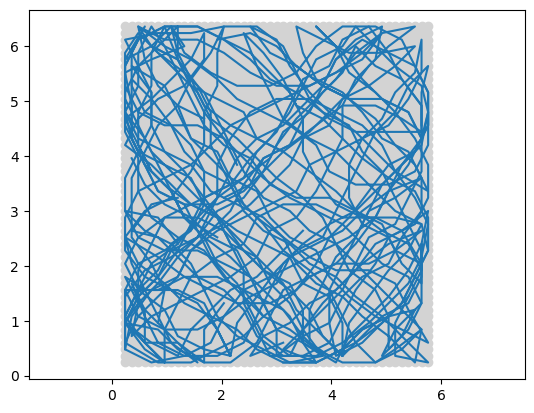

In [34]:
plt.figure()

plt.plot(training_traj[::10, :, 1].T, training_traj[::10, :, 0].T, c='tab:blue')
# plt.plot(validation_traj[:, :, 1].T, validation_traj[:, :, 0].T, c='tab:orange')
# plt.plot(testing_traj[:, :, 1].T, testing_traj[:, :, 0].T, c='tab:green')
plt.scatter(yx[:, 1] * 0.6, yx[:, 0] * 0.6, c='lightgray')

plt.axis('equal')
plt.show()

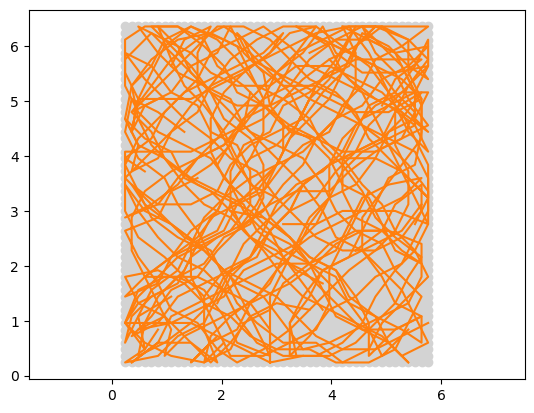

In [35]:
plt.figure()

# plt.plot(training_traj[::10, :, 1].T, training_traj[::10, :, 0].T, c='tab:blue')
plt.plot(validation_traj[:, :, 1].T, validation_traj[:, :, 0].T, c='tab:orange')
# plt.plot(testing_traj[:, :, 1].T, testing_traj[:, :, 0].T, c='tab:green')
plt.scatter(yx[:, 1] * 0.6, yx[:, 0] * 0.6, c='lightgray')

plt.axis('equal')
plt.show()

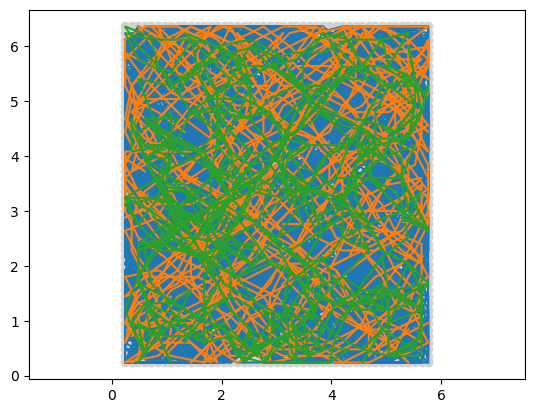

In [27]:
plt.figure()

plt.plot(training_traj[:, :, 1].T, training_traj[:, :, 0].T, c='tab:blue')
plt.plot(validation_traj[:, :, 1].T, validation_traj[:, :, 0].T, c='tab:orange')
plt.plot(testing_traj[:, :, 1].T, testing_traj[:, :, 0].T, c='tab:green')
plt.scatter(yx[:, 1] * 0.6, yx[:, 0] * 0.6, c='lightgray')

plt.axis('equal')
plt.show()

In [28]:
np.save(f'./Data/training_traj.npy', training_traj)
np.save(f'./Data/validation_traj.npy', validation_traj)
np.save(f'./Data/testing_traj.npy', testing_traj)

In [3]:
training_traj = np.load(f'./Data/training_traj.npy')[:, :, :-1]
validation_traj = np.load(f'./Data/validation_traj.npy')[:, :, :-1]
testing_traj = np.load(f'./Data/testing_traj.npy')[:, :, :-1]

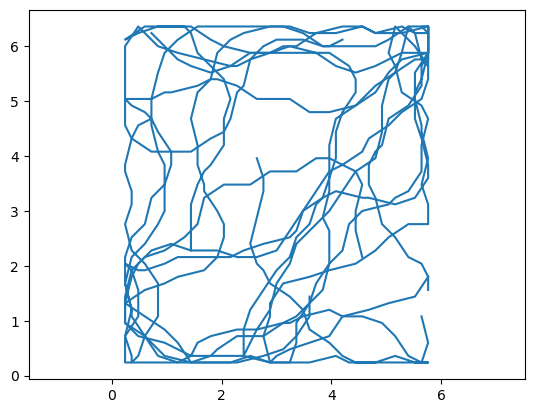

In [9]:
plt.figure()

plt.plot(training_traj[:5, :, 1].T, training_traj[:5, :, 0].T, c='tab:blue')

plt.axis('equal')
plt.show()

In [11]:
trajectory_set = np.load('./trajectory_set.npy')
crowdsourcing_set = np.load('./crowdsourcing_set.npy')

In [12]:
trajectory_set.shape, crowdsourcing_set.shape

((19201, 60, 2), (1978, 60, 2))

In [13]:
def rotate_traj(extra_traj, rotate_theat):
    seq = np.array(extra_traj)[:, ::-1]
    
    x = seq[:, 0]
    y = seq[:, 1]
    
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)
    
    theta = theta + rotate_theat / 180 * np.pi
    
    new_x = r * np.cos(theta)
    new_y = r * np.sin(theta)
    new_traj = np.stack((new_y, new_x), axis=1)
    
    return new_traj

In [14]:
def check_traj(traj):
    
    is_in_map = np.all(((min_xpos - 0.25) < traj[:, 1]) & (traj[:, 1] < (max_xpos + 0.25)) & ((min_ypos - 0.25) < traj[:, 0]) & (traj[:, 0] < (max_ypos + 0.25)))
    
    return is_in_map

In [52]:
min_xpos = pos[:, 1].min()
min_ypos = pos[:, 0].min()
max_xpos = pos[:, 1].max()
max_ypos = pos[:, 0].max()

In [65]:
np.random.rand(2) * (max_ypos, max_xpos)

array([6.99563955, 8.15760606])

In [329]:
make_trajectories = []

for i in tqdm(range(10000)):
    select_x = np.random.rand(2) * (max_ypos - min_ypos, max_xpos - min_xpos) + (min_ypos, min_xpos)
    count = 0
    
    while True and count < 1000:
        rnd_idx = np.random.choice(len(trajectory_set), 1)[0]
        select_traj = trajectory_set[rnd_idx][:10] / 0.6

        if np.random.rand() < 0.5:
            select_traj = select_traj[:, ::-1]

        random_rotate_angle = np.random.choice(36, 1) * 10
        select_traj = rotate_traj(select_traj, random_rotate_angle)

        traj = select_traj + select_x

        if check_traj(traj):
            make_trajectories.append(traj)
            break
        count += 1

100%|██████████| 10000/10000 [00:37<00:00, 267.63it/s]


In [330]:
make_trajectories[0]

array([[5.8159697 , 8.08713177],
       [5.41916094, 7.49540489],
       [4.76202901, 6.81408513],
       [4.44666532, 6.18872531],
       [4.07268531, 5.47950652],
       [3.67185355, 4.78149101],
       [3.439795  , 4.13420321],
       [3.12427608, 3.25456338],
       [2.81908745, 2.5303183 ],
       [2.43207715, 1.63032333]])

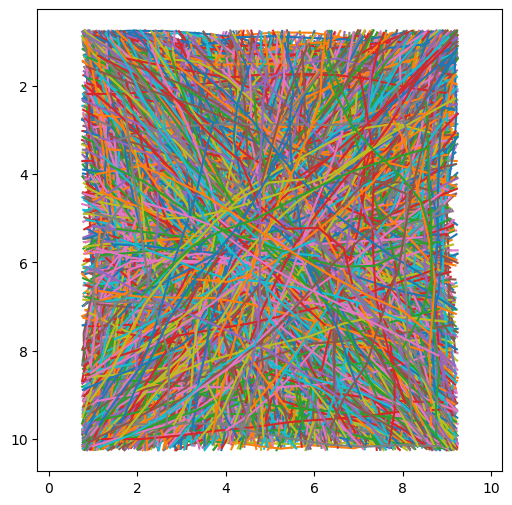

In [331]:
plt.figure(figsize=(6, 6))
plt.scatter(pos[:, 1], pos[:, 0], s=1)

for traj in make_trajectories:
    plt.plot(traj[:, 1], traj[:, 0])

plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [332]:
new_make_trajectories = []

for traj in make_trajectories:
    pred = gp.predict(traj)
    
    new_traj = np.concatenate((traj, pred), axis=-1)
    
    new_make_trajectories.append(new_traj)

In [333]:
new_make_trajectories = np.array(new_make_trajectories)

In [334]:
new_make_trajectories.shape

(9693, 10, 5)

In [335]:
np.save('./make_trajectory.npy', new_make_trajectories)